# GO enrichment for retained paralogs example

Here I describe how to get to a GO enrichment analysis for retained paralogs from a WGD event. To this end I use the `wgd` library to perform mixture modeling and select paralogs from a particular mixture component. The GO enrichment is then performed using the `goenrich` library (https://github.com/jdrudolph/goenrich). 

In [13]:
from wgd.viz import plot_selection
from wgd.modeling import fit_bgmm, get_component_probabilities, filter_group_data, plot_all_models_bgmm, get_array_for_mixture
import matplotlib.pyplot as plt
import pandas as pd
import goenrich

## 1. Get the distributions

The distributions were computed using the '`wgd ks`' and '`wgd syn`' commands from the '`wgd`' CLI.

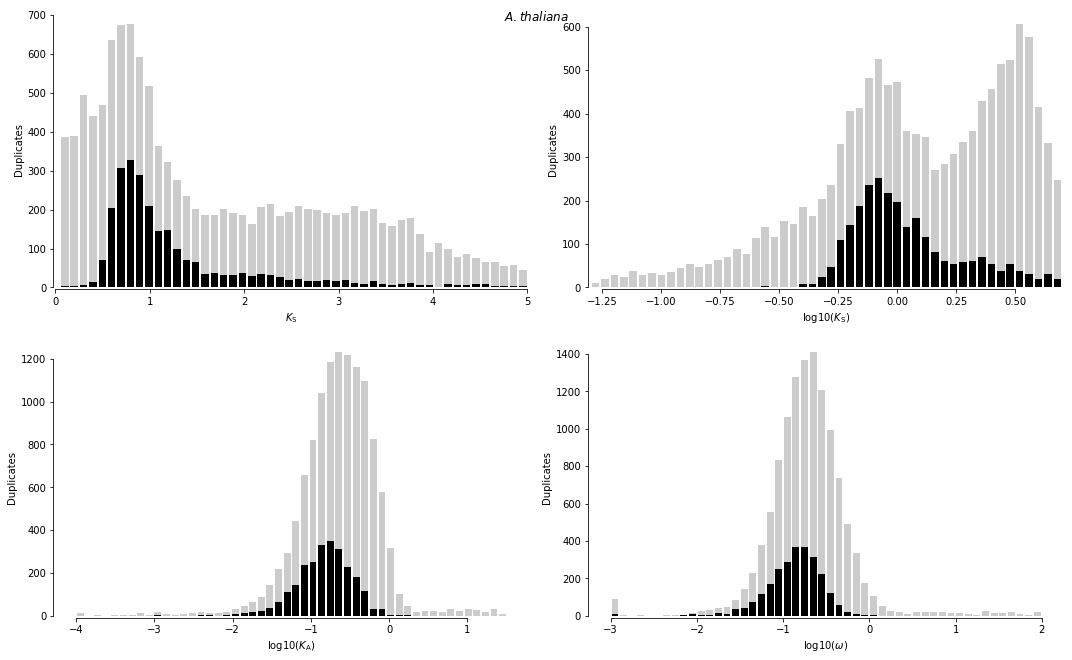

In [30]:
full_ks = pd.read_csv('./data/ath.ks.tsv', sep='\t', index_col=0)
anchors_ks = pd.read_csv('./data/ath_anchors.ks.tsv', sep='\t', index_col=0)
plot_selection(dists=[full_ks, anchors_ks], title='$A. thaliana$');

## 2. Mixture modeling

As an illustration I will use th `wgd` library directly here, note however that the '`wgd mix`' command in the `wgd` CLI provides all tools for performing the analysis in this section without the need to code. Use for example the command below:

If all goes correct, you will now have the data frame with for each pair the posterior probability to come from one of the two components. Anyway, I now proceed by performing the analysis directly in the notebook:

In [31]:
data = filter_group_data(df=anchors_ks, min_ks=0.05, max_ks=3)
X = get_array_for_mixture(data)
models = fit_bgmm(X, n1=1, n2=3, n_init=10, max_iter=10000)

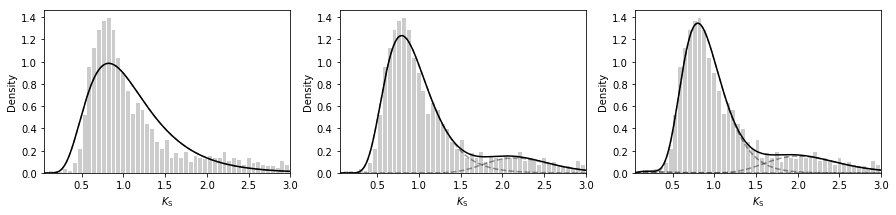

In [32]:
fig, ax = plt.subplots(1,3, figsize=(15,3))
for i, m in enumerate(models):
    plot_mixture(m, data=X, ax=ax[i], l=0.05, u=3, bins=50)

It seems more parsimonious to use the two-component model, so I will use that one. I will  now select components from the first component.

In [34]:
model = models[1]
anchors_ks = anchors_ks[anchors_ks["Ks"] > 0]  # filter out Ks = 0, as log is -inf!
ks_anchors_mix = get_component_probabilities(df=anchors_ks, model=model)
ks_anchors_mix.head()

,AlignmentCoverage,AlignmentIdentity,AlignmentLength,AlignmentLengthStripped,Distance,Family,Ka,Ks,Node,Omega,Outlier,Paralog1,Paralog2,WeightOutliersExcluded,WeightOutliersIncluded,log(Ks),p_component1,p_component2
AT4G25420__AT5G51810,0.74008,0.78731,1512.0,1119.0,0.29210,GF_000197,0.1211,0.7495,13.0,0.1615,False,AT4G25420,AT5G51810,1.00,1.00,-0.288349,1.000000,5.872964e-09
AT1G15540__AT1G80320,0.62698,0.59599,1512.0,948.0,0.73190,GF_000197,0.3517,68.8938,20.0,0.0051,True,AT1G80320,AT1G15540,0.00,1.00,4.232566,1.000000,4.218759e-42
AT1G54280__AT3G13900,0.91834,0.84937,4041.0,3711.0,0.12266,GF_000206,0.0581,1.0479,13.0,0.0554,False,AT3G13900,AT1G54280,1.00,1.00,0.046788,0.999935,6.534271e-05
AT1G17500__AT1G72700,0.90052,0.84776,4041.0,3639.0,0.12898,GF_000206,0.0254,0.9952,14.0,0.0256,False,AT1G72700,AT1G17500,1.00,1.00,-0.004812,0.999982,1.819869e-05
AT1G72700__AT3G13900,0.91017,0.74008,4041.0,3678.0,0.32305,GF_000206,0.0796,2.4245,15.0,0.0328,False,AT3G13900,AT1G72700,0.25,0.25,0.885625,0.040212,9.597877e-01


In [35]:
paralogs = set(ks_anchors_mix[ks_anchors_mix['p_component1'] > 0.95]['Paralog1'])
paralogs = paralogs | set(ks_anchors_mix[ks_anchors_mix['p_component1'] > 0.95]['Paralog2'])
print('{} paralogs were selected'.format(len(paralogs)))

4332 paralogs were selected


## 3. GO enrichment analysis

I have the genes of interest, _i.e._ the ones I hope to resemble paralogs retained from a WGD represented by the peak I modeled with the Bayesian Gaussian mixture model. Now I will perform GO enrichment on the selected paralogs using the `goenrich` library. To this end I use the whole gene ontology obo graph (retrieved at http://purl.obolibrary.org/obo/go/go-basic.obo and stored in the directory `~/godb`) and the GO annotatoin for _A. thaliana_ obtained from the GO consortium website (http://geneontology.org/gene-associations/gene_association.tair.gz, also in the directory `~/godb`).

**Set up the GO enrichment analysis**

In [38]:
ontology = goenrich.obo.ontology('/home/arzwa/godb/go-basic.obo')
gene2go = goenrich.read.sgd('/home/arzwa/godb/gene_association.tair.gz')
values = {k: set(v) for k,v in gene2go.groupby('go_id')['db_object_name']}
background_attribute = 'sgd'
goenrich.enrich.propagate(ontology, values, background_attribute)

/home/arzwa/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2961: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


**Perform enrichment analysis and get significant results**

The underlying test is the `hypergeometric test hypergeom.sf(x, M, n, N)`. All $p$-values are corrected for multiple testing using the Benjamini-Hochberge method before a significance cut-off of $\alpha=0.05$ is applied.

In [40]:
df = goenrich.enrich.analyze(ontology, paralogs, background_attribute)
df = df.dropna()
enriched = df[df['rejected'] == 1]

In [45]:
BP = enriched[enriched['namespace'] == 'biological_process']
BP = BP.sort_values('q', ascending=True)
print("There are {} enriched BP terms".format(len(BP)))
BP.head(n=15)

There are 327 enriched BP terms


,term,q,rejected,p,x,n,M,N,name,namespace
24535,GO:0048468,8.966824e-10,1.0,6.625732e-13,80,320,39891,4332,cell development,biological_process
4131,GO:0005976,8.966824e-10,1.0,5.660499e-13,104,465,39891,4332,polysaccharide metabolic process,biological_process
31150,GO:0071396,7.478127e-09,1.0,9.209516e-12,90,397,39891,4332,cellular response to lipid,biological_process
33743,GO:0090627,3.298399e-08,1.0,6.499309e-11,48,163,39891,4332,plant epidermal cell differentiation,biological_process
33678,GO:0090558,4.277078e-08,1.0,9.481208e-11,67,272,39891,4332,plant epidermis development,biological_process
9059,GO:0016051,6.029326e-08,1.0,1.485056e-10,84,379,39891,4332,carbohydrate biosynthetic process,biological_process
4816,GO:0006812,2.998255e-07,1.0,9.204314e-10,89,425,39891,4332,cation transport,biological_process
19256,GO:0042546,3.751221e-07,1.0,1.293524e-09,58,234,39891,4332,cell wall biogenesis,biological_process
526,GO:0000904,4.628327e-07,1.0,1.823971e-09,58,236,39891,4332,cell morphogenesis involved in differentiation,biological_process
189,GO:0000271,5.615480e-07,1.0,2.766246e-09,53,209,39891,4332,polysaccharide biosynthetic process,biological_process


$M$ is the total number of genes (background set), $N$ the number of genes in the ste of interest, $n$ the number of genes annotated with the particular term in the background set and $x$ the number of genes with the term of interest annotated in the test set of interest.

Notice how many development and defense related terms appear.